In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime


%matplotlib inline
from RL_env.config import config
from RL_env.marketdata.yahoodownloader import YahooDownloader
from RL_env.preprocessing.preprocessors import FeatureEngineer
from RL_env.preprocessing.data import data_split
from RL_env.env.env_stocktrading import StockTradingEnv
from RL_env.model.models import DRLAgent,DRLEnsembleAgent
from RL_env.trade.backtest import backtest_stats, get_baseline, backtest_plot
from RL_env.trade.backtest import convert_daily_return_to_pyfolio_ts,get_daily_return


from pprint import pprint
from pyfolio import timeseries

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
start_date=config.START_DATE
end_date=config.END_DATE

In [4]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = config.PRO1_10_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (52840, 8)


In [5]:
# df.to_csv('susa.csv')

In [6]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,32.791668,32.833332,28.645832,31.083332,2792700,BIIB,0
1,2000-01-03,17.062500,17.125000,16.125000,10.345668,1368700,CB,0
2,2000-01-03,21.250000,28.765625,20.593750,25.170780,9040800,EA,0
3,2000-01-03,19.500000,19.500000,18.750000,14.684854,582000,ECL,0
4,2000-01-03,34.375000,34.437500,33.750000,12.261371,581900,ED,0


In [7]:
df.tail(10)

,date,open,high,low,close,volume,tic,day
52830,2020-12-31,243.470001,245.190002,241.100006,244.860001,978100,BIIB,3
52831,2020-12-31,152.360001,154.119995,150.619995,153.227814,1220300,CB,3
52832,2020-12-31,141.910004,143.860001,141.910004,143.251572,1689900,EA,3
52833,2020-12-31,215.250000,216.839996,214.729996,215.876328,752300,ECL,3
52834,2020-12-31,70.879997,72.320000,70.760002,70.778145,2081400,ED,3
52835,2020-12-31,112.559998,113.959999,112.320000,113.860001,2052200,FISV,3
52836,2020-12-31,405.720001,408.850006,402.309998,405.225250,223500,GWW,3
52837,2020-12-31,93.750000,94.190002,92.800003,92.224770,559200,HAS,3
52838,2020-12-31,61.529999,62.290001,61.330002,61.070087,1813100,K,3
52839,2020-12-31,63.549999,64.739998,62.709999,63.518803,1424900,WELL,3


In [8]:
df.shape

(52840, 8)

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = True)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [10]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4
0,2000-01-03,32.791668,32.833332,28.645832,31.083332,2792700,BIIB,0,0.0,33.006987,27.055513,0.0,-66.666667,100.0,31.083332,31.083332,-0.667163,-1.100104,-0.795576
5284,2000-01-03,17.062500,17.125000,16.125000,10.345668,1368700,CB,0,0.0,33.006987,27.055513,0.0,-66.666667,100.0,10.345668,10.345668,-0.667163,-1.100104,-0.795576
10568,2000-01-03,21.250000,28.765625,20.593750,25.170780,9040800,EA,0,0.0,33.006987,27.055513,0.0,-66.666667,100.0,25.170780,25.170780,1.432978,0.889116,-0.795576
15852,2000-01-03,19.500000,19.500000,18.750000,14.684854,582000,ECL,0,0.0,33.006987,27.055513,0.0,-66.666667,100.0,14.684854,14.684854,-0.416591,-0.538867,-0.795576
21136,2000-01-03,34.375000,34.437500,33.750000,12.261371,581900,ED,0,0.0,33.006987,27.055513,0.0,-66.666667,100.0,12.261371,12.261371,-0.165033,-0.180363,-0.795576


In [11]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values 
    cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [12]:
df.shape

(50320, 20)

In [13]:
df.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,63.083332,63.666668,58.020832,59.250000,5691300,BIIB,1,0.095880,75.095405,57.665012,48.264690,-50.384603,18.702324,63.631944,63.052951,11.597235,2.533477,6.494071,"[[0.004130015641651464, 0.0006147056771538668,..."
1,2001-01-02,43.187500,43.187500,40.812500,26.614565,1676500,CB,1,0.415880,28.645922,23.808830,54.411886,81.691394,11.865872,25.865298,25.120649,-0.550809,-0.800307,0.047412,"[[0.004130015641651464, 0.0006147056771538668,..."
2,2001-01-02,21.843750,21.906250,18.531250,19.395668,2344400,EA,1,-0.073481,22.700748,16.909376,46.734297,-8.001071,19.520729,20.018321,22.083456,-0.271239,-0.316409,1.948695,"[[0.004130015641651464, 0.0006147056771538668,..."
3,2001-01-02,21.593750,21.593750,21.156250,16.778002,571600,ECL,1,0.233035,17.533826,15.656909,55.364303,51.380266,28.817171,16.503550,15.675060,-0.134961,-0.144981,0.182250,"[[0.004130015641651464, 0.0006147056771538668,..."
4,2001-01-02,38.312500,38.375000,37.375000,14.559716,341300,ED,1,0.292290,15.425207,13.357479,56.975500,62.182164,17.098691,14.354601,13.677717,-0.132214,-0.141810,2.095564,"[[0.004130015641651464, 0.0006147056771538668,..."
5,2001-01-02,7.976563,7.979167,7.270833,7.395833,6213000,FISV,1,-0.244366,9.932237,7.010472,43.040280,-134.359701,37.705632,8.474826,8.666927,-0.492035,-0.677342,-0.875176,"[[0.004130015641651464, 0.0006147056771538668,..."
6,2001-01-02,35.750000,36.812500,35.437500,25.105249,614000,GWW,1,0.117821,27.725351,21.941272,55.088501,15.587434,30.646330,24.934109,22.765905,2.394513,1.222160,-0.056710,"[[0.004130015641651464, 0.0006147056771538668,..."
7,2001-01-02,10.750000,11.000000,10.312500,6.384250,1159300,HAS,1,-0.120995,7.248093,5.160572,47.365693,2.604495,17.863344,6.527414,6.652660,-0.745701,-1.369243,-0.670841,"[[0.004130015641651464, 0.0006147056771538668,..."
8,2001-01-02,26.062500,26.937500,26.062500,14.225390,383700,K,1,0.167841,14.706496,12.399455,53.826920,57.079280,25.967403,13.779411,13.569747,1.228201,0.801194,-0.152140,"[[0.004130015641651464, 0.0006147056771538668,..."
9,2001-01-02,16.250000,16.375000,16.062500,4.649143,124000,WELL,1,-0.058460,5.021913,4.652647,42.250178,-203.132996,20.336797,4.871048,4.908655,-0.673180,-1.118346,-0.680685,"[[0.004130015641651464, 0.0006147056771538668,..."


In [14]:
train = data_split(df, config.START_DATE,'2019-01-01')
trade = data_split(df, '2019-01-02', config.END_DATE)

In [15]:
train.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,63.083332,63.666668,58.020832,59.250000,5691300,BIIB,1,0.095880,75.095405,57.665012,48.264690,-50.384603,18.702324,63.631944,63.052951,11.597235,2.533477,6.494071,"[[0.004130015641651464, 0.0006147056771538668,..."
0,2001-01-02,43.187500,43.187500,40.812500,26.614565,1676500,CB,1,0.415880,28.645922,23.808830,54.411886,81.691394,11.865872,25.865298,25.120649,-0.550809,-0.800307,0.047412,"[[0.004130015641651464, 0.0006147056771538668,..."
0,2001-01-02,21.843750,21.906250,18.531250,19.395668,2344400,EA,1,-0.073481,22.700748,16.909376,46.734297,-8.001071,19.520729,20.018321,22.083456,-0.271239,-0.316409,1.948695,"[[0.004130015641651464, 0.0006147056771538668,..."
0,2001-01-02,21.593750,21.593750,21.156250,16.778002,571600,ECL,1,0.233035,17.533826,15.656909,55.364303,51.380266,28.817171,16.503550,15.675060,-0.134961,-0.144981,0.182250,"[[0.004130015641651464, 0.0006147056771538668,..."
0,2001-01-02,38.312500,38.375000,37.375000,14.559716,341300,ED,1,0.292290,15.425207,13.357479,56.975500,62.182164,17.098691,14.354601,13.677717,-0.132214,-0.141810,2.095564,"[[0.004130015641651464, 0.0006147056771538668,..."
0,2001-01-02,7.976563,7.979167,7.270833,7.395833,6213000,FISV,1,-0.244366,9.932237,7.010472,43.040280,-134.359701,37.705632,8.474826,8.666927,-0.492035,-0.677342,-0.875176,"[[0.004130015641651464, 0.0006147056771538668,..."
0,2001-01-02,35.750000,36.812500,35.437500,25.105249,614000,GWW,1,0.117821,27.725351,21.941272,55.088501,15.587434,30.646330,24.934109,22.765905,2.394513,1.222160,-0.056710,"[[0.004130015641651464, 0.0006147056771538668,..."
0,2001-01-02,10.750000,11.000000,10.312500,6.384250,1159300,HAS,1,-0.120995,7.248093,5.160572,47.365693,2.604495,17.863344,6.527414,6.652660,-0.745701,-1.369243,-0.670841,"[[0.004130015641651464, 0.0006147056771538668,..."
0,2001-01-02,26.062500,26.937500,26.062500,14.225390,383700,K,1,0.167841,14.706496,12.399455,53.826920,57.079280,25.967403,13.779411,13.569747,1.228201,0.801194,-0.152140,"[[0.004130015641651464, 0.0006147056771538668,..."
0,2001-01-02,16.250000,16.375000,16.062500,4.649143,124000,WELL,1,-0.058460,5.021913,4.652647,42.250178,-203.132996,20.336797,4.871048,4.908655,-0.673180,-1.118346,-0.680685,"[[0.004130015641651464, 0.0006147056771538668,..."


In [16]:
train.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
4526,2018-12-31,294.559998,302.480011,294.200012,300.920013,1064300,BIIB,0,-7.952601,342.175996,274.283009,44.815817,-72.974108,10.113885,312.895000,317.580166,3.829787,1.574802,3.124452,"[[0.000506167875894775, 7.354470846918256e-05,..."
4526,2018-12-31,128.000000,129.509995,127.680000,122.905113,1616000,CB,0,-0.823085,127.512921,115.669580,50.295941,-19.132721,1.031621,122.990633,122.126219,-0.591569,-0.895432,-0.543061,"[[0.000506167875894775, 7.354470846918256e-05,..."
4526,2018-12-31,80.000000,80.379997,78.300003,78.613785,2942400,EA,0,-2.720770,85.597933,74.666194,36.980819,-73.307067,36.096067,81.622779,90.129061,-0.360370,-0.446866,0.042929,"[[0.000506167875894775, 7.354470846918256e-05,..."
4526,2018-12-31,144.869995,147.580002,144.479996,144.223236,1199400,ECL,0,-2.850954,159.246404,135.470733,45.983474,-85.856629,24.410735,149.167172,148.891651,0.834579,0.606815,1.763879,"[[0.000506167875894775, 7.354470846918256e-05,..."
4526,2018-12-31,76.480003,76.870003,75.680000,69.582092,1670200,ED,0,-0.587233,78.062459,68.169139,45.696873,-95.507832,19.496323,72.371382,70.967562,-0.517539,-0.728855,0.116797,"[[0.000506167875894775, 7.354470846918256e-05,..."
4526,2018-12-31,73.379997,73.620003,72.620003,73.489998,1538300,FISV,0,-1.470788,80.392245,69.128754,45.171673,-74.724872,20.279496,75.865666,77.085500,0.056163,0.054642,-0.755782,"[[0.000506167875894775, 7.354470846918256e-05,..."
4526,2018-12-31,281.700012,284.850006,279.339996,269.825195,460400,GWW,0,-5.310091,298.136886,249.873200,43.640605,-63.371723,6.560356,279.967395,280.883427,2.671591,1.300625,1.195394,"[[0.000506167875894775, 7.354470846918256e-05,..."
4526,2018-12-31,81.290001,81.629997,80.139999,75.489403,1147100,HAS,0,-3.177538,84.202282,70.740066,36.711152,-73.177051,35.175293,81.403747,85.669721,-0.720228,-1.273782,-0.039743,"[[0.000506167875894775, 7.354470846918256e-05,..."
4526,2018-12-31,57.189999,57.450001,56.549999,51.962708,2093000,K,0,-1.527906,58.288490,50.203382,35.282657,-126.123636,42.598716,54.860657,58.005941,-0.311656,-0.373466,-0.639706,"[[0.000506167875894775, 7.354470846918256e-05,..."
4526,2018-12-31,69.599998,69.599998,68.089996,62.340950,1421800,WELL,0,-0.162645,67.513984,60.594380,51.596076,-97.563394,17.867962,63.754347,61.038805,0.199725,0.182092,-0.104066,"[[0.000506167875894775, 7.354470846918256e-05,..."


In [17]:
trade.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2019-01-02,296.839996,307.130005,296.540009,304.690002,1336500,BIIB,2,-6.883490,338.548087,275.007919,46.228711,-50.056617,2.547273,312.327334,316.939999,3.887478,1.586676,3.146006,"[[0.0005066681368321641, 7.283769329740312e-05..."
0,2019-01-02,127.650002,128.610001,126.070000,121.106941,1391900,CB,2,-0.731880,126.772174,115.870002,48.046324,-52.250612,8.981361,122.925298,122.024655,-0.602524,-0.922621,-0.551165,"[[0.0005066681368321641, 7.283769329740312e-05..."
0,2019-01-02,77.220001,80.639999,77.199997,80.068306,3176600,EA,2,-2.422293,85.141135,74.754382,39.023145,-62.467787,40.456014,81.361098,89.570499,-0.338863,-0.413794,0.060656,"[[0.0005066681368321641, 7.283769329740312e-05..."
0,2019-01-02,145.500000,146.309998,143.539993,141.844772,1429900,ECL,2,-2.789131,157.906236,135.333718,43.816056,-97.290404,27.109473,148.745690,148.716692,0.771547,0.571853,1.729742,"[[0.0005066681368321641, 7.283769329740312e-05..."
0,2019-01-02,76.320000,76.370003,74.790001,68.380836,1764100,ED,2,-0.777325,78.259511,67.497954,43.321931,-118.508924,24.586754,72.328913,70.955884,-0.517918,-0.729641,0.096885,"[[0.0005066681368321641, 7.283769329740312e-05..."
0,2019-01-02,72.209999,73.489998,71.820000,72.209999,2278600,FISV,2,-1.449864,79.758890,69.070110,43.328222,-88.473753,24.844304,75.615666,76.947833,0.055998,0.054486,-0.763005,"[[0.0005066681368321641, 7.283769329740312e-05..."
0,2019-01-02,278.890015,279.910004,274.589996,264.301788,789200,GWW,2,-5.287574,293.318135,251.112245,41.601859,-86.574782,14.015511,279.026760,279.705923,2.660183,1.297513,1.182383,"[[0.0005066681368321641, 7.283769329740312e-05..."
0,2019-01-02,79.889999,81.050003,79.260002,74.309441,1759000,HAS,2,-3.081544,82.939627,70.978853,35.376532,-78.990984,38.408772,80.859294,85.348188,-0.718846,-1.268854,-0.071924,"[[0.0005066681368321641, 7.283769329740312e-05..."
0,2019-01-02,56.779999,57.099998,56.110001,51.625473,2245900,K,2,-1.518603,57.716941,50.135993,34.611970,-125.698067,45.175516,54.698827,57.825352,-0.305264,-0.364223,-0.636042,"[[0.0005066681368321641, 7.283769329740312e-05..."
0,2019-01-02,68.790001,68.919998,66.820000,60.436863,2328100,WELL,2,-0.346233,67.614030,60.041665,47.340240,-153.649286,26.879083,63.688483,61.126574,0.170679,0.157584,-0.116173,"[[0.0005066681368321641, 7.283769329740312e-05..."


In [18]:
trade.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
504,2020-12-31,243.470001,245.190002,241.100006,244.860001,978100,BIIB,3,-1.749108,251.711240,240.647756,46.248308,-55.001066,8.535083,245.146665,257.544166,2.904468,1.362121,1.169206,"[[0.0019030092171187817, 0.0003383602352798351..."
504,2020-12-31,152.360001,154.119995,150.619995,153.227814,1220300,CB,3,1.686056,154.054737,149.022014,60.080294,60.526642,16.712198,150.776695,140.478808,-0.374223,-0.468761,-0.620467,"[[0.0019030092171187817, 0.0003383602352798351..."
504,2020-12-31,141.910004,143.860001,141.910004,143.251572,1689900,EA,3,4.121315,147.201203,127.809902,62.169770,94.985958,32.763460,132.566676,128.478653,-0.065107,-0.067323,0.545686,"[[0.0019030092171187817, 0.0003383602352798351..."
504,2020-12-31,215.250000,216.839996,214.729996,215.876328,752300,ECL,3,0.419317,226.131927,210.861967,53.059164,-47.571303,4.629603,217.759670,208.843539,0.506974,0.410103,2.575110,"[[0.0019030092171187817, 0.0003383602352798351..."
504,2020-12-31,70.879997,72.320000,70.760002,70.778145,2081400,ED,3,-1.557552,74.545328,67.140253,43.923371,-61.840806,12.272347,72.520429,75.583521,-0.672136,-1.115155,0.128608,"[[0.0019030092171187817, 0.0003383602352798351..."
504,2020-12-31,112.559998,113.959999,112.320000,113.860001,2052200,FISV,3,0.472372,118.118568,110.069430,55.923152,-23.287932,12.287593,113.997333,108.126499,0.608689,0.475419,-0.535000,"[[0.0019030092171187817, 0.0003383602352798351..."
504,2020-12-31,405.720001,408.850006,402.309998,405.225250,223500,GWW,3,2.559056,412.639763,396.562352,56.019007,-57.919989,7.223765,407.028398,391.450851,2.558978,1.269473,1.644593,"[[0.0019030092171187817, 0.0003383602352798351..."
504,2020-12-31,93.750000,94.190002,92.800003,92.224770,559200,HAS,3,1.068369,94.573902,86.813304,57.363351,64.261552,21.869661,90.999573,87.834681,-0.772411,-1.480214,-0.356204,"[[0.0019030092171187817, 0.0003383602352798351..."
504,2020-12-31,61.529999,62.290001,61.330002,61.070087,1813100,K,3,-0.366267,61.737198,59.920148,46.907832,-52.006599,14.897189,61.305163,62.411819,-0.337813,-0.412207,-0.717106,"[[0.0019030092171187817, 0.0003383602352798351..."
504,2020-12-31,63.549999,64.739998,62.709999,63.518803,1424900,WELL,3,0.267170,65.430426,60.653705,54.673178,-13.278359,2.182991,63.045014,59.666386,0.040097,0.039314,-0.102565,"[[0.0019030092171187817, 0.0003383602352798351..."


In [19]:
from RL_env.env.env_portfolio import StockPortfolioEnv

In [20]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 10, State Space: 10


In [21]:
train.tic.unique()

array(['BIIB', 'CB', 'EA', 'ECL', 'ED', 'FISV', 'GWW', 'HAS', 'K', 'WELL'],
      dtype=object)

In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.0025, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "turbulence_threshold":330
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)


In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [24]:
# initialize
agent = DRLAgent(env = env_train)

In [34]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [35]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=500000)

Logging to tensorboard_log/a2c\a2c_29
------------------------------------
| time/                 |          |
|    fps                | 431      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -14.2    |
|    explained_variance | 1.43e-06 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 5.42e+06 |
|    std                | 1        |
|    value_loss         | 1.72e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 399       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -14.2     |
|    explained_variance | -9.54e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 1

------------------------------------
| time/                 |          |
|    fps                | 439      |
|    iterations         | 1500     |
|    time_elapsed       | 17       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -14.2    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 1499     |
|    policy_loss        | 2.36e+07 |
|    std                | 0.997    |
|    value_loss         | 3.22e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 438      |
|    iterations         | 1600     |
|    time_elapsed       | 18       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -14.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1599     |
|    policy_loss        | 3.55e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 453      |
|    iterations         | 2900     |
|    time_elapsed       | 31       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -14.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2899     |
|    policy_loss        | 7.88e+06 |
|    std                | 0.991    |
|    value_loss         | 4.04e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 454       |
|    iterations         | 3000      |
|    time_elapsed       | 33        |
|    total_timesteps    | 15000     |
| train/                |           |
|    entropy_loss       | -14.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 2999      |
|    policy_loss        | 9

------------------------------------
| time/                 |          |
|    fps                | 466      |
|    iterations         | 4300     |
|    time_elapsed       | 46       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -14      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 4299     |
|    policy_loss        | 3.27e+07 |
|    std                | 0.984    |
|    value_loss         | 8.4e+12  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 467      |
|    iterations         | 4400     |
|    time_elapsed       | 47       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -14      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 4399     |
|    policy_loss        | 4.64e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 474      |
|    iterations         | 5600     |
|    time_elapsed       | 58       |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -13.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 5599     |
|    policy_loss        | 7.28e+06 |
|    std                | 0.972    |
|    value_loss         | 3.65e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 5700     |
|    time_elapsed       | 59       |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -13.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 5699     |
|    policy_loss        | 9.75e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 7000     |
|    time_elapsed       | 73       |
|    total_timesteps    | 35000    |
| train/                |          |
|    entropy_loss       | -13.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 6999     |
|    policy_loss        | 2.8e+07  |
|    std                | 0.965    |
|    value_loss         | 4.38e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 476      |
|    iterations         | 7100     |
|    time_elapsed       | 74       |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -13.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 7099     |
|    policy_loss        | 3.55e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 8300     |
|    time_elapsed       | 87       |
|    total_timesteps    | 41500    |
| train/                |          |
|    entropy_loss       | -13.8    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 8299     |
|    policy_loss        | 6.25e+06 |
|    std                | 0.961    |
|    value_loss         | 3.08e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 8400     |
|    time_elapsed       | 88       |
|    total_timesteps    | 42000    |
| train/                |          |
|    entropy_loss       | -13.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8399     |
|    policy_loss        | 8.43e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 474       |
|    iterations         | 9700      |
|    time_elapsed       | 102       |
|    total_timesteps    | 48500     |
| train/                |           |
|    entropy_loss       | -13.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 9699      |
|    policy_loss        | 2.55e+07  |
|    std                | 0.958     |
|    value_loss         | 4.3e+12   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 9800     |
|    time_elapsed       | 103      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -13.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9799     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 11000    |
|    time_elapsed       | 115      |
|    total_timesteps    | 55000    |
| train/                |          |
|    entropy_loss       | -13.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 10999    |
|    policy_loss        | 8.34e+06 |
|    std                | 0.947    |
|    value_loss         | 3.36e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 474      |
|    iterations         | 11100    |
|    time_elapsed       | 116      |
|    total_timesteps    | 55500    |
| train/                |          |
|    entropy_loss       | -13.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 11099    |
|    policy_loss        | 9.22e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 474      |
|    iterations         | 12400    |
|    time_elapsed       | 130      |
|    total_timesteps    | 62000    |
| train/                |          |
|    entropy_loss       | -13.5    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 12399    |
|    policy_loss        | 2.06e+07 |
|    std                | 0.938    |
|    value_loss         | 2.63e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 473      |
|    iterations         | 12500    |
|    time_elapsed       | 131      |
|    total_timesteps    | 62500    |
| train/                |          |
|    entropy_loss       | -13.5    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 12499    |
|    policy_loss        | 2.95e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 473       |
|    iterations         | 13700     |
|    time_elapsed       | 144       |
|    total_timesteps    | 68500     |
| train/                |           |
|    entropy_loss       | -13.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 13699     |
|    policy_loss        | 6.13e+06  |
|    std                | 0.925     |
|    value_loss         | 2.32e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 473      |
|    iterations         | 13800    |
|    time_elapsed       | 145      |
|    total_timesteps    | 69000    |
| train/                |          |
|    entropy_loss       | -13.4    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 13799    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 472       |
|    iterations         | 15100     |
|    time_elapsed       | 159       |
|    total_timesteps    | 75500     |
| train/                |           |
|    entropy_loss       | -13.3     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 15099     |
|    policy_loss        | 2.14e+07  |
|    std                | 0.914     |
|    value_loss         | 2.94e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 472      |
|    iterations         | 15200    |
|    time_elapsed       | 160      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | -13.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 15199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 472      |
|    iterations         | 16400    |
|    time_elapsed       | 173      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -13.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16399    |
|    policy_loss        | 5.24e+06 |
|    std                | 0.905    |
|    value_loss         | 1.97e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 472      |
|    iterations         | 16500    |
|    time_elapsed       | 174      |
|    total_timesteps    | 82500    |
| train/                |          |
|    entropy_loss       | -13.2    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 16499    |
|    policy_loss        | 9.46e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 471      |
|    iterations         | 17800    |
|    time_elapsed       | 188      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -13.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 17799    |
|    policy_loss        | 1.63e+07 |
|    std                | 0.897    |
|    value_loss         | 2.01e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 471      |
|    iterations         | 17900    |
|    time_elapsed       | 189      |
|    total_timesteps    | 89500    |
| train/                |          |
|    entropy_loss       | -13.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 17899    |
|    policy_loss        | 2.77e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 471       |
|    iterations         | 19200     |
|    time_elapsed       | 203       |
|    total_timesteps    | 96000     |
| train/                |           |
|    entropy_loss       | -13       |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 19199     |
|    policy_loss        | 6.98e+06  |
|    std                | 0.891     |
|    value_loss         | 3.49e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 471      |
|    iterations         | 19300    |
|    time_elapsed       | 204      |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -13      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 19299    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 469      |
|    iterations         | 20600    |
|    time_elapsed       | 219      |
|    total_timesteps    | 103000   |
| train/                |          |
|    entropy_loss       | -12.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 20599    |
|    policy_loss        | 2.55e+07 |
|    std                | 0.882    |
|    value_loss         | 5.17e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 469      |
|    iterations         | 20700    |
|    time_elapsed       | 220      |
|    total_timesteps    | 103500   |
| train/                |          |
|    entropy_loss       | -12.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 20699    |
|    policy_loss        | 3.83e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 466      |
|    iterations         | 21900    |
|    time_elapsed       | 234      |
|    total_timesteps    | 109500   |
| train/                |          |
|    entropy_loss       | -12.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21899    |
|    policy_loss        | 5.94e+06 |
|    std                | 0.875    |
|    value_loss         | 2.42e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 466      |
|    iterations         | 22000    |
|    time_elapsed       | 235      |
|    total_timesteps    | 110000   |
| train/                |          |
|    entropy_loss       | -12.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21999    |
|    policy_loss        | 6.16e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 466      |
|    iterations         | 23300    |
|    time_elapsed       | 249      |
|    total_timesteps    | 116500   |
| train/                |          |
|    entropy_loss       | -12.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23299    |
|    policy_loss        | 2.41e+07 |
|    std                | 0.865    |
|    value_loss         | 4.7e+12  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 466      |
|    iterations         | 23400    |
|    time_elapsed       | 250      |
|    total_timesteps    | 117000   |
| train/                |          |
|    entropy_loss       | -12.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23399    |
|    policy_loss        | 2.91e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 466      |
|    iterations         | 24600    |
|    time_elapsed       | 263      |
|    total_timesteps    | 123000   |
| train/                |          |
|    entropy_loss       | -12.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 24599    |
|    policy_loss        | 6.64e+06 |
|    std                | 0.856    |
|    value_loss         | 3.78e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 467      |
|    iterations         | 24700    |
|    time_elapsed       | 264      |
|    total_timesteps    | 123500   |
| train/                |          |
|    entropy_loss       | -12.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 24699    |
|    policy_loss        | 9.06e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 468      |
|    iterations         | 26000    |
|    time_elapsed       | 277      |
|    total_timesteps    | 130000   |
| train/                |          |
|    entropy_loss       | -12.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 25999    |
|    policy_loss        | 2.29e+07 |
|    std                | 0.848    |
|    value_loss         | 4.81e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 468      |
|    iterations         | 26100    |
|    time_elapsed       | 278      |
|    total_timesteps    | 130500   |
| train/                |          |
|    entropy_loss       | -12.5    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 26099    |
|    policy_loss        | 3.53e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 469      |
|    iterations         | 27300    |
|    time_elapsed       | 290      |
|    total_timesteps    | 136500   |
| train/                |          |
|    entropy_loss       | -12.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 27299    |
|    policy_loss        | 6.18e+06 |
|    std                | 0.841    |
|    value_loss         | 2.78e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 469       |
|    iterations         | 27400     |
|    time_elapsed       | 291       |
|    total_timesteps    | 137000    |
| train/                |           |
|    entropy_loss       | -12.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 27399     |
|    policy_loss        | 8

-------------------------------------
| time/                 |           |
|    fps                | 471       |
|    iterations         | 28700     |
|    time_elapsed       | 304       |
|    total_timesteps    | 143500    |
| train/                |           |
|    entropy_loss       | -12.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 28699     |
|    policy_loss        | 2.75e+07  |
|    std                | 0.833     |
|    value_loss         | 4.31e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 471      |
|    iterations         | 28800    |
|    time_elapsed       | 305      |
|    total_timesteps    | 144000   |
| train/                |          |
|    entropy_loss       | -12.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 28799    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 472       |
|    iterations         | 30000     |
|    time_elapsed       | 317       |
|    total_timesteps    | 150000    |
| train/                |           |
|    entropy_loss       | -12.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 29999     |
|    policy_loss        | 5e+06     |
|    std                | 0.826     |
|    value_loss         | 2.24e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 472       |
|    iterations         | 30100     |
|    time_elapsed       | 318       |
|    total_timesteps    | 150500    |
| train/                |           |
|    entropy_loss       | -12.3     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 30099     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 473       |
|    iterations         | 31400     |
|    time_elapsed       | 331       |
|    total_timesteps    | 157000    |
| train/                |           |
|    entropy_loss       | -12.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 31399     |
|    policy_loss        | 1.96e+07  |
|    std                | 0.821     |
|    value_loss         | 3.12e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 473       |
|    iterations         | 31500     |
|    time_elapsed       | 332       |
|    total_timesteps    | 157500    |
| train/                |           |
|    entropy_loss       | -12.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 31499     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 474      |
|    iterations         | 32700    |
|    time_elapsed       | 344      |
|    total_timesteps    | 163500   |
| train/                |          |
|    entropy_loss       | -12.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 32699    |
|    policy_loss        | 5.2e+06  |
|    std                | 0.811    |
|    value_loss         | 1.97e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 474       |
|    iterations         | 32800     |
|    time_elapsed       | 345       |
|    total_timesteps    | 164000    |
| train/                |           |
|    entropy_loss       | -12.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 32799     |
|    policy_loss        | 7

------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 34100    |
|    time_elapsed       | 358      |
|    total_timesteps    | 170500   |
| train/                |          |
|    entropy_loss       | -12      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 34099    |
|    policy_loss        | 1.68e+07 |
|    std                | 0.807    |
|    value_loss         | 2.83e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 34200    |
|    time_elapsed       | 359      |
|    total_timesteps    | 171000   |
| train/                |          |
|    entropy_loss       | -12      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 34199    |
|    policy_loss        | 2.56e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 35500    |
|    time_elapsed       | 373      |
|    total_timesteps    | 177500   |
| train/                |          |
|    entropy_loss       | -11.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 35499    |
|    policy_loss        | 6.64e+06 |
|    std                | 0.799    |
|    value_loss         | 3.88e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 475       |
|    iterations         | 35600     |
|    time_elapsed       | 374       |
|    total_timesteps    | 178000    |
| train/                |           |
|    entropy_loss       | -11.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 35599     |
|    policy_loss        | 8

------------------------------------
| time/                 |          |
|    fps                | 476      |
|    iterations         | 36900    |
|    time_elapsed       | 386      |
|    total_timesteps    | 184500   |
| train/                |          |
|    entropy_loss       | -11.8    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 36899    |
|    policy_loss        | 2.92e+07 |
|    std                | 0.791    |
|    value_loss         | 5.69e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 477      |
|    iterations         | 37000    |
|    time_elapsed       | 387      |
|    total_timesteps    | 185000   |
| train/                |          |
|    entropy_loss       | -11.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 36999    |
|    policy_loss        | 4.91e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 477      |
|    iterations         | 38200    |
|    time_elapsed       | 400      |
|    total_timesteps    | 191000   |
| train/                |          |
|    entropy_loss       | -11.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38199    |
|    policy_loss        | 6.3e+06  |
|    std                | 0.782    |
|    value_loss         | 3.92e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 477      |
|    iterations         | 38300    |
|    time_elapsed       | 401      |
|    total_timesteps    | 191500   |
| train/                |          |
|    entropy_loss       | -11.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38299    |
|    policy_loss        | 7.07e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 478      |
|    iterations         | 39600    |
|    time_elapsed       | 413      |
|    total_timesteps    | 198000   |
| train/                |          |
|    entropy_loss       | -11.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 39599    |
|    policy_loss        | 1.93e+07 |
|    std                | 0.777    |
|    value_loss         | 3.52e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 478      |
|    iterations         | 39700    |
|    time_elapsed       | 414      |
|    total_timesteps    | 198500   |
| train/                |          |
|    entropy_loss       | -11.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 39699    |
|    policy_loss        | 2.66e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 478      |
|    iterations         | 40900    |
|    time_elapsed       | 427      |
|    total_timesteps    | 204500   |
| train/                |          |
|    entropy_loss       | -11.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 40899    |
|    policy_loss        | 8.95e+06 |
|    std                | 0.77     |
|    value_loss         | 4.44e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 478      |
|    iterations         | 41000    |
|    time_elapsed       | 428      |
|    total_timesteps    | 205000   |
| train/                |          |
|    entropy_loss       | -11.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 40999    |
|    policy_loss        | 9.3e+06  |
|

------------------------------------
| time/                 |          |
|    fps                | 479      |
|    iterations         | 42300    |
|    time_elapsed       | 441      |
|    total_timesteps    | 211500   |
| train/                |          |
|    entropy_loss       | -11.4    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 42299    |
|    policy_loss        | 2.07e+07 |
|    std                | 0.76     |
|    value_loss         | 3.62e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 479      |
|    iterations         | 42400    |
|    time_elapsed       | 442      |
|    total_timesteps    | 212000   |
| train/                |          |
|    entropy_loss       | -11.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 42399    |
|    policy_loss        | 2.94e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 480       |
|    iterations         | 43600     |
|    time_elapsed       | 454       |
|    total_timesteps    | 218000    |
| train/                |           |
|    entropy_loss       | -11.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 43599     |
|    policy_loss        | 5.34e+06  |
|    std                | 0.754     |
|    value_loss         | 2.36e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 480      |
|    iterations         | 43700    |
|    time_elapsed       | 454      |
|    total_timesteps    | 218500   |
| train/                |          |
|    entropy_loss       | -11.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 480      |
|    iterations         | 45000    |
|    time_elapsed       | 468      |
|    total_timesteps    | 225000   |
| train/                |          |
|    entropy_loss       | -11.2    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 44999    |
|    policy_loss        | 1.78e+07 |
|    std                | 0.747    |
|    value_loss         | 3.56e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 480      |
|    iterations         | 45100    |
|    time_elapsed       | 469      |
|    total_timesteps    | 225500   |
| train/                |          |
|    entropy_loss       | -11.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 45099    |
|    policy_loss        | 2.53e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 481      |
|    iterations         | 46300    |
|    time_elapsed       | 481      |
|    total_timesteps    | 231500   |
| train/                |          |
|    entropy_loss       | -11.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46299    |
|    policy_loss        | 4.56e+06 |
|    std                | 0.741    |
|    value_loss         | 1.98e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 481       |
|    iterations         | 46400     |
|    time_elapsed       | 482       |
|    total_timesteps    | 232000    |
| train/                |           |
|    entropy_loss       | -11.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 46399     |
|    policy_loss        | 5

------------------------------------
| time/                 |          |
|    fps                | 481      |
|    iterations         | 47700    |
|    time_elapsed       | 495      |
|    total_timesteps    | 238500   |
| train/                |          |
|    entropy_loss       | -11.1    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 47699    |
|    policy_loss        | 1.81e+07 |
|    std                | 0.738    |
|    value_loss         | 2.97e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 481       |
|    iterations         | 47800     |
|    time_elapsed       | 496       |
|    total_timesteps    | 239000    |
| train/                |           |
|    entropy_loss       | -11.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 47799     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 482      |
|    iterations         | 49000    |
|    time_elapsed       | 508      |
|    total_timesteps    | 245000   |
| train/                |          |
|    entropy_loss       | -11      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 48999    |
|    policy_loss        | 3.81e+06 |
|    std                | 0.73     |
|    value_loss         | 1.53e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 482       |
|    iterations         | 49100     |
|    time_elapsed       | 509       |
|    total_timesteps    | 245500    |
| train/                |           |
|    entropy_loss       | -11       |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 49099     |
|    policy_loss        | 7

-------------------------------------
| time/                 |           |
|    fps                | 482       |
|    iterations         | 50400     |
|    time_elapsed       | 522       |
|    total_timesteps    | 252000    |
| train/                |           |
|    entropy_loss       | -10.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 50399     |
|    policy_loss        | 1.31e+07  |
|    std                | 0.724     |
|    value_loss         | 1.98e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 482       |
|    iterations         | 50500     |
|    time_elapsed       | 523       |
|    total_timesteps    | 252500    |
| train/                |           |
|    entropy_loss       | -10.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 50499     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 482      |
|    iterations         | 51800    |
|    time_elapsed       | 536      |
|    total_timesteps    | 259000   |
| train/                |          |
|    entropy_loss       | -10.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 51799    |
|    policy_loss        | 6.4e+06  |
|    std                | 0.718    |
|    value_loss         | 3.53e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 482      |
|    iterations         | 51900    |
|    time_elapsed       | 537      |
|    total_timesteps    | 259500   |
| train/                |          |
|    entropy_loss       | -10.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 51899    |
|    policy_loss        | 8.36e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 483      |
|    iterations         | 53200    |
|    time_elapsed       | 550      |
|    total_timesteps    | 266000   |
| train/                |          |
|    entropy_loss       | -10.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53199    |
|    policy_loss        | 1.72e+07 |
|    std                | 0.715    |
|    value_loss         | 3.86e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 483      |
|    iterations         | 53300    |
|    time_elapsed       | 551      |
|    total_timesteps    | 266500   |
| train/                |          |
|    entropy_loss       | -10.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53299    |
|    policy_loss        | 3e+07    |
|

-------------------------------------
| time/                 |           |
|    fps                | 483       |
|    iterations         | 54500     |
|    time_elapsed       | 563       |
|    total_timesteps    | 272500    |
| train/                |           |
|    entropy_loss       | -10.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 54499     |
|    policy_loss        | 6.7e+06   |
|    std                | 0.711     |
|    value_loss         | 3.47e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 483      |
|    iterations         | 54600    |
|    time_elapsed       | 564      |
|    total_timesteps    | 273000   |
| train/                |          |
|    entropy_loss       | -10.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54599    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 483       |
|    iterations         | 55900     |
|    time_elapsed       | 577       |
|    total_timesteps    | 279500    |
| train/                |           |
|    entropy_loss       | -10.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 55899     |
|    policy_loss        | 1.6e+07   |
|    std                | 0.705     |
|    value_loss         | 3.63e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 483      |
|    iterations         | 56000    |
|    time_elapsed       | 578      |
|    total_timesteps    | 280000   |
| train/                |          |
|    entropy_loss       | -10.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 55999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 483      |
|    iterations         | 57200    |
|    time_elapsed       | 591      |
|    total_timesteps    | 286000   |
| train/                |          |
|    entropy_loss       | -10.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57199    |
|    policy_loss        | 5.34e+06 |
|    std                | 0.696    |
|    value_loss         | 3.25e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 483      |
|    iterations         | 57300    |
|    time_elapsed       | 592      |
|    total_timesteps    | 286500   |
| train/                |          |
|    entropy_loss       | -10.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57299    |
|    policy_loss        | 6.36e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 484      |
|    iterations         | 58600    |
|    time_elapsed       | 605      |
|    total_timesteps    | 293000   |
| train/                |          |
|    entropy_loss       | -10.4    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 58599    |
|    policy_loss        | 2.31e+07 |
|    std                | 0.688    |
|    value_loss         | 3.95e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 484      |
|    iterations         | 58700    |
|    time_elapsed       | 606      |
|    total_timesteps    | 293500   |
| train/                |          |
|    entropy_loss       | -10.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 58699    |
|    policy_loss        | 2.68e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 484      |
|    iterations         | 59900    |
|    time_elapsed       | 618      |
|    total_timesteps    | 299500   |
| train/                |          |
|    entropy_loss       | -10.3    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 59899    |
|    policy_loss        | 4.8e+06  |
|    std                | 0.68     |
|    value_loss         | 2.75e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 484       |
|    iterations         | 60000     |
|    time_elapsed       | 619       |
|    total_timesteps    | 300000    |
| train/                |           |
|    entropy_loss       | -10.3     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 59999     |
|    policy_loss        | 7

-------------------------------------
| time/                 |           |
|    fps                | 484       |
|    iterations         | 61300     |
|    time_elapsed       | 632       |
|    total_timesteps    | 306500    |
| train/                |           |
|    entropy_loss       | -10.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 61299     |
|    policy_loss        | 1.5e+07   |
|    std                | 0.672     |
|    value_loss         | 2.73e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 484       |
|    iterations         | 61400     |
|    time_elapsed       | 633       |
|    total_timesteps    | 307000    |
| train/                |           |
|    entropy_loss       | -10.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 61399     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 484      |
|    iterations         | 62600    |
|    time_elapsed       | 645      |
|    total_timesteps    | 313000   |
| train/                |          |
|    entropy_loss       | -10.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 62599    |
|    policy_loss        | 4.54e+06 |
|    std                | 0.666    |
|    value_loss         | 2.55e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 484      |
|    iterations         | 62700    |
|    time_elapsed       | 646      |
|    total_timesteps    | 313500   |
| train/                |          |
|    entropy_loss       | -10.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 62699    |
|    policy_loss        | 6.12e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 485       |
|    iterations         | 64000     |
|    time_elapsed       | 659       |
|    total_timesteps    | 320000    |
| train/                |           |
|    entropy_loss       | -9.99     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 63999     |
|    policy_loss        | 1.41e+07  |
|    std                | 0.661     |
|    value_loss         | 2.6e+12   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 64100    |
|    time_elapsed       | 660      |
|    total_timesteps    | 320500   |
| train/                |          |
|    entropy_loss       | -9.99    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 64099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 65300    |
|    time_elapsed       | 672      |
|    total_timesteps    | 326500   |
| train/                |          |
|    entropy_loss       | -9.92    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65299    |
|    policy_loss        | 3.24e+06 |
|    std                | 0.656    |
|    value_loss         | 1.55e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 65400    |
|    time_elapsed       | 673      |
|    total_timesteps    | 327000   |
| train/                |          |
|    entropy_loss       | -9.92    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65399    |
|    policy_loss        | 6e+06    |
|

-------------------------------------
| time/                 |           |
|    fps                | 485       |
|    iterations         | 66700     |
|    time_elapsed       | 686       |
|    total_timesteps    | 333500    |
| train/                |           |
|    entropy_loss       | -9.8      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 66699     |
|    policy_loss        | 1.32e+07  |
|    std                | 0.649     |
|    value_loss         | 1.59e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 66800    |
|    time_elapsed       | 687      |
|    total_timesteps    | 334000   |
| train/                |          |
|    entropy_loss       | -9.79    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66799    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 68100    |
|    time_elapsed       | 700      |
|    total_timesteps    | 340500   |
| train/                |          |
|    entropy_loss       | -9.75    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 68099    |
|    policy_loss        | 5.88e+06 |
|    std                | 0.646    |
|    value_loss         | 4.26e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 68200    |
|    time_elapsed       | 701      |
|    total_timesteps    | 341000   |
| train/                |          |
|    entropy_loss       | -9.73    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 68199    |
|    policy_loss        | 7.14e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 69500     |
|    time_elapsed       | 714       |
|    total_timesteps    | 347500    |
| train/                |           |
|    entropy_loss       | -9.66     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 69499     |
|    policy_loss        | 2.33e+07  |
|    std                | 0.64      |
|    value_loss         | 4.89e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 69600    |
|    time_elapsed       | 715      |
|    total_timesteps    | 348000   |
| train/                |          |
|    entropy_loss       | -9.64    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 69599    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 70800     |
|    time_elapsed       | 727       |
|    total_timesteps    | 354000    |
| train/                |           |
|    entropy_loss       | -9.51     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 70799     |
|    policy_loss        | 6e+06     |
|    std                | 0.631     |
|    value_loss         | 3.65e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 70900     |
|    time_elapsed       | 728       |
|    total_timesteps    | 354500    |
| train/                |           |
|    entropy_loss       | -9.52     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 70899     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 72200    |
|    time_elapsed       | 741      |
|    total_timesteps    | 361000   |
| train/                |          |
|    entropy_loss       | -9.4     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 72199    |
|    policy_loss        | 1.49e+07 |
|    std                | 0.624    |
|    value_loss         | 3.99e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 72300    |
|    time_elapsed       | 743      |
|    total_timesteps    | 361500   |
| train/                |          |
|    entropy_loss       | -9.4     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 72299    |
|    policy_loss        | 2.84e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 73500     |
|    time_elapsed       | 755       |
|    total_timesteps    | 367500    |
| train/                |           |
|    entropy_loss       | -9.31     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 73499     |
|    policy_loss        | 5.88e+06  |
|    std                | 0.619     |
|    value_loss         | 3.79e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 73600     |
|    time_elapsed       | 756       |
|    total_timesteps    | 368000    |
| train/                |           |
|    entropy_loss       | -9.3      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 73599     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 74900    |
|    time_elapsed       | 769      |
|    total_timesteps    | 374500   |
| train/                |          |
|    entropy_loss       | -9.2     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 74899    |
|    policy_loss        | 1.59e+07 |
|    std                | 0.612    |
|    value_loss         | 3.21e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 75000    |
|    time_elapsed       | 770      |
|    total_timesteps    | 375000   |
| train/                |          |
|    entropy_loss       | -9.18    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74999    |
|    policy_loss        | 2.3e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 76200    |
|    time_elapsed       | 782      |
|    total_timesteps    | 381000   |
| train/                |          |
|    entropy_loss       | -9.07    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76199    |
|    policy_loss        | 5.73e+06 |
|    std                | 0.605    |
|    value_loss         | 3.11e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 76300    |
|    time_elapsed       | 783      |
|    total_timesteps    | 381500   |
| train/                |          |
|    entropy_loss       | -9.05    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76299    |
|    policy_loss        | 5.94e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 77600    |
|    time_elapsed       | 797      |
|    total_timesteps    | 388000   |
| train/                |          |
|    entropy_loss       | -8.97    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 77599    |
|    policy_loss        | 1.36e+07 |
|    std                | 0.599    |
|    value_loss         | 3.32e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 77700     |
|    time_elapsed       | 798       |
|    total_timesteps    | 388500    |
| train/                |           |
|    entropy_loss       | -8.97     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 77699     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 78900    |
|    time_elapsed       | 810      |
|    total_timesteps    | 394500   |
| train/                |          |
|    entropy_loss       | -8.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 78899    |
|    policy_loss        | 3.99e+06 |
|    std                | 0.594    |
|    value_loss         | 2.35e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 79000     |
|    time_elapsed       | 811       |
|    total_timesteps    | 395000    |
| train/                |           |
|    entropy_loss       | -8.87     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 78999     |
|    policy_loss        | 6

------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 80300    |
|    time_elapsed       | 824      |
|    total_timesteps    | 401500   |
| train/                |          |
|    entropy_loss       | -8.79    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 80299    |
|    policy_loss        | 1.55e+07 |
|    std                | 0.588    |
|    value_loss         | 3.08e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 80400    |
|    time_elapsed       | 825      |
|    total_timesteps    | 402000   |
| train/                |          |
|    entropy_loss       | -8.78    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 80399    |
|    policy_loss        | 1.86e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 81600     |
|    time_elapsed       | 838       |
|    total_timesteps    | 408000    |
| train/                |           |
|    entropy_loss       | -8.73     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 81599     |
|    policy_loss        | 2.81e+06  |
|    std                | 0.586     |
|    value_loss         | 1.71e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 81700    |
|    time_elapsed       | 839      |
|    total_timesteps    | 408500   |
| train/                |          |
|    entropy_loss       | -8.73    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 81699    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 83000     |
|    time_elapsed       | 852       |
|    total_timesteps    | 415000    |
| train/                |           |
|    entropy_loss       | -8.68     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 82999     |
|    policy_loss        | 1.37e+07  |
|    std                | 0.583     |
|    value_loss         | 2.33e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 83100     |
|    time_elapsed       | 853       |
|    total_timesteps    | 415500    |
| train/                |           |
|    entropy_loss       | -8.69     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 83099     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 84400    |
|    time_elapsed       | 866      |
|    total_timesteps    | 422000   |
| train/                |          |
|    entropy_loss       | -8.58    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 84399    |
|    policy_loss        | 4.74e+06 |
|    std                | 0.577    |
|    value_loss         | 4.03e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 84500     |
|    time_elapsed       | 867       |
|    total_timesteps    | 422500    |
| train/                |           |
|    entropy_loss       | -8.57     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 84499     |
|    policy_loss        | 6

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 85800    |
|    time_elapsed       | 879      |
|    total_timesteps    | 429000   |
| train/                |          |
|    entropy_loss       | -8.47    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85799    |
|    policy_loss        | 1.3e+07  |
|    std                | 0.572    |
|    value_loss         | 4.98e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 85900     |
|    time_elapsed       | 880       |
|    total_timesteps    | 429500    |
| train/                |           |
|    entropy_loss       | -8.47     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 85899     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 87100    |
|    time_elapsed       | 893      |
|    total_timesteps    | 435500   |
| train/                |          |
|    entropy_loss       | -8.37    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 87099    |
|    policy_loss        | 4.34e+06 |
|    std                | 0.566    |
|    value_loss         | 3.71e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 87200    |
|    time_elapsed       | 894      |
|    total_timesteps    | 436000   |
| train/                |          |
|    entropy_loss       | -8.36    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 87199    |
|    policy_loss        | 4.93e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 88500    |
|    time_elapsed       | 907      |
|    total_timesteps    | 442500   |
| train/                |          |
|    entropy_loss       | -8.22    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 88499    |
|    policy_loss        | 1.69e+07 |
|    std                | 0.558    |
|    value_loss         | 5.27e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 88600     |
|    time_elapsed       | 908       |
|    total_timesteps    | 443000    |
| train/                |           |
|    entropy_loss       | -8.2      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 88599     |
|    policy_loss        | 2

-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 89800     |
|    time_elapsed       | 922       |
|    total_timesteps    | 449000    |
| train/                |           |
|    entropy_loss       | -8.1      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 89799     |
|    policy_loss        | 4.29e+06  |
|    std                | 0.552     |
|    value_loss         | 3.92e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 89900    |
|    time_elapsed       | 923      |
|    total_timesteps    | 449500   |
| train/                |          |
|    entropy_loss       | -8.09    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 89899    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 91200     |
|    time_elapsed       | 937       |
|    total_timesteps    | 456000    |
| train/                |           |
|    entropy_loss       | -7.99     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 91199     |
|    policy_loss        | 1.49e+07  |
|    std                | 0.546     |
|    value_loss         | 4.23e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 91300     |
|    time_elapsed       | 938       |
|    total_timesteps    | 456500    |
| train/                |           |
|    entropy_loss       | -8        |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 91299     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 92500     |
|    time_elapsed       | 950       |
|    total_timesteps    | 462500    |
| train/                |           |
|    entropy_loss       | -7.93     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 92499     |
|    policy_loss        | 2.82e+06  |
|    std                | 0.543     |
|    value_loss         | 2.84e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 486       |
|    iterations         | 92600     |
|    time_elapsed       | 951       |
|    total_timesteps    | 463000    |
| train/                |           |
|    entropy_loss       | -7.93     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 92599     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 93900    |
|    time_elapsed       | 964      |
|    total_timesteps    | 469500   |
| train/                |          |
|    entropy_loss       | -7.81    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 93899    |
|    policy_loss        | 1.45e+07 |
|    std                | 0.537    |
|    value_loss         | 3.43e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 94000    |
|    time_elapsed       | 965      |
|    total_timesteps    | 470000   |
| train/                |          |
|    entropy_loss       | -7.81    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 93999    |
|    policy_loss        | 1.82e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 95200     |
|    time_elapsed       | 977       |
|    total_timesteps    | 476000    |
| train/                |           |
|    entropy_loss       | -7.7      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 95199     |
|    policy_loss        | 2.7e+06   |
|    std                | 0.531     |
|    value_loss         | 2.58e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 95300    |
|    time_elapsed       | 978      |
|    total_timesteps    | 476500   |
| train/                |          |
|    entropy_loss       | -7.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95299    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 96600     |
|    time_elapsed       | 991       |
|    total_timesteps    | 483000    |
| train/                |           |
|    entropy_loss       | -7.6      |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 96599     |
|    policy_loss        | 1.15e+07  |
|    std                | 0.526     |
|    value_loss         | 3.2e+12   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 96700    |
|    time_elapsed       | 992      |
|    total_timesteps    | 483500   |
| train/                |          |
|    entropy_loss       | -7.61    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 96699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 97900    |
|    time_elapsed       | 1004     |
|    total_timesteps    | 489500   |
| train/                |          |
|    entropy_loss       | -7.55    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 97899    |
|    policy_loss        | 3.13e+06 |
|    std                | 0.524    |
|    value_loss         | 2e+11    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 98000    |
|    time_elapsed       | 1005     |
|    total_timesteps    | 490000   |
| train/                |          |
|    entropy_loss       | -7.54    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 97999    |
|    policy_loss        | 3.87e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 99300    |
|    time_elapsed       | 1018     |
|    total_timesteps    | 496500   |
| train/                |          |
|    entropy_loss       | -7.44    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99299    |
|    policy_loss        | 1.14e+07 |
|    std                | 0.518    |
|    value_loss         | 2.43e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 99400    |
|    time_elapsed       | 1019     |
|    total_timesteps    | 497000   |
| train/                |          |
|    entropy_loss       | -7.43    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99399    |
|    policy_loss        | 1.7e+07  |
|

In [36]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 512,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=500000)

{'batch_size': 512, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_25
begin_total_asset:100000
end_total_asset:1204342.778454255
Sharpe:  0.8373658466088052
begin_total_asset:100000
end_total_asset:1125998.2087595065
Sharpe:  0.8275012991915022
begin_total_asset:100000
end_total_asset:1169373.5369642104
Sharpe:  0.8247932632757562
begin_total_asset:100000
end_total_asset:1157811.7140451677
Sharpe:  0.8117833616715137
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 1.16e+06                |
|    total_reward    | [0, 0.02578084403596... |
| time/              |                         |
|    episodes        | 4                       |
|    fps             | 35                      |
|    time_elapsed    | 504                     |
|    total timesteps | 18108                   |
| train/             |               

begin_total_asset:100000
end_total_asset:1211195.3555227027
Sharpe:  0.8650706803285131
begin_total_asset:100000
end_total_asset:1185601.1779299483
Sharpe:  0.8557419270786417
begin_total_asset:100000
end_total_asset:1235951.6758483471
Sharpe:  0.860000818366541
begin_total_asset:100000
end_total_asset:1192470.7887980253
Sharpe:  0.8530123690727704
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 1.19e+06                |
|    total_reward    | [0, 0.02263764608545... |
| time/              |                         |
|    episodes        | 28                      |
|    fps             | 14                      |
|    time_elapsed    | 8811                    |
|    total timesteps | 126756                  |
| train/             |                         |
|    actor_loss      | -4.87e+07               |
|    critic_loss     | 8.98e+11                |
|    ent_coef        | 281                     |
|    ent_coe

begin_total_asset:100000
end_total_asset:1266166.547274622
Sharpe:  0.8690457802573279
begin_total_asset:100000
end_total_asset:1205546.4384365152
Sharpe:  0.8489456409573136
begin_total_asset:100000
end_total_asset:1233815.0462718054
Sharpe:  0.861292985468664
begin_total_asset:100000
end_total_asset:1086736.428015251
Sharpe:  0.8233993720526579
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 1.09e+06                |
|    total_reward    | [0, 0.02662803500260... |
| time/              |                         |
|    episodes        | 52                      |
|    fps             | 14                      |
|    time_elapsed    | 15810                   |
|    total timesteps | 235404                  |
| train/             |                         |
|    actor_loss      | -4.65e+07               |
|    critic_loss     | 1.15e+12                |
|    ent_coef        | 381                     |
|    ent_coef_

begin_total_asset:100000
end_total_asset:1297069.0164029528
Sharpe:  0.8847611565157518
begin_total_asset:100000
end_total_asset:1157259.826881357
Sharpe:  0.8450055962209536
begin_total_asset:100000
end_total_asset:1196291.7130708927
Sharpe:  0.8529631206575493
begin_total_asset:100000
end_total_asset:1189831.4507393022
Sharpe:  0.8641511346232285
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 1.19e+06                |
|    total_reward    | [0, 0.02328893906322... |
| time/              |                         |
|    episodes        | 76                      |
|    fps             | 16                      |
|    time_elapsed    | 20661                   |
|    total timesteps | 344052                  |
| train/             |                         |
|    actor_loss      | -4.73e+07               |
|    critic_loss     | 8.98e+11                |
|    ent_coef        | 436                     |
|    ent_coe

begin_total_asset:100000
end_total_asset:1212363.3183956826
Sharpe:  0.8756739219190569
begin_total_asset:100000
end_total_asset:1322456.1330353816
Sharpe:  0.9068451880845625
begin_total_asset:100000
end_total_asset:1303198.679058346
Sharpe:  0.9005831743290618
begin_total_asset:100000
end_total_asset:1291078.6475981488
Sharpe:  0.895603825876647
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 1.29e+06                |
|    total_reward    | [0, 0.02629798170447... |
| time/              |                         |
|    episodes        | 100                     |
|    fps             | 17                      |
|    time_elapsed    | 25361                   |
|    total timesteps | 452700                  |
| train/             |                         |
|    actor_loss      | -4.33e+07               |
|    critic_loss     | 9.88e+11                |
|    ent_coef        | 1.65e+03                |
|    ent_coef

In [37]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 512}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=500000)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 512}
Using cpu device
Logging to tensorboard_log/ppo\ppo_27
-----------------------------
| time/              |      |
|    fps             | 443  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 435           |
|    iterations           | 2             |
|    time_elapsed         | 9             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.1350722e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -14.2         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 5.93e+12      |
|    n_updates            | 10        

--------------------------------------------
| time/                   |                |
|    fps                  | 416            |
|    iterations           | 10             |
|    time_elapsed         | 49             |
|    total_timesteps      | 20480          |
| train/                  |                |
|    approx_kl            | -3.5390258e-08 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -14.2          |
|    explained_variance   | 1.19e-07       |
|    learning_rate        | 0.0001         |
|    loss                 | 8.93e+13       |
|    n_updates            | 90             |
|    policy_gradient_loss | -3.06e-08      |
|    std                  | 1              |
|    value_loss           | 1.84e+14       |
--------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 418           |
|    iteratio

begin_total_asset:100000
end_total_asset:1137855.2335326872
Sharpe:  0.845691529941203
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.14e+06                |
|    total_reward         | [0, 0.01740201770547... |
| time/                   |                         |
|    fps                  | 421                     |
|    iterations           | 18                      |
|    time_elapsed         | 87                      |
|    total_timesteps      | 36864                   |
| train/                  |                         |
|    approx_kl            | -1.8114224e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.47e+13             

------------------------------------------
| time/                   |              |
|    fps                  | 419          |
|    iterations           | 26           |
|    time_elapsed         | 126          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 6.565824e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0001       |
|    loss                 | 5.55e+13     |
|    n_updates            | 250          |
|    policy_gradient_loss | -1.65e-07    |
|    std                  | 1            |
|    value_loss           | 1.07e+14     |
------------------------------------------
begin_total_asset:100000
end_total_asset:1216953.6910311591
Sharpe:  0.8694008536823404
-----------------------------------------------------
| environment/            |              

-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.31e+06                |
|    total_reward         | [0, 0.01889064801284... |
| time/                   |                         |
|    fps                  | 420                     |
|    iterations           | 34                      |
|    time_elapsed         | 165                     |
|    total_timesteps      | 69632                   |
| train/                  |                         |
|    approx_kl            | 2.4214387e-08           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 1.19e-07                |
|    learning_rate        | 0.0001                  |
|    loss                 | 7.52e+13                |
|    n_updates            | 330                     |
|    policy_gradient_loss | 

begin_total_asset:100000
end_total_asset:1107085.8014215822
Sharpe:  0.840367220473566
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.11e+06                |
|    total_reward         | [0, 0.01782893217294... |
| time/                   |                         |
|    fps                  | 420                     |
|    iterations           | 42                      |
|    time_elapsed         | 204                     |
|    total_timesteps      | 86016                   |
| train/                  |                         |
|    approx_kl            | 1.03376806e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | -2.38e-07               |
|    learning_rate        | 0.0001                  |
|    loss                 | 8.97e+12             

------------------------------------------
| time/                   |              |
|    fps                  | 421          |
|    iterations           | 50           |
|    time_elapsed         | 242          |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 4.656613e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 7.26e+13     |
|    n_updates            | 490          |
|    policy_gradient_loss | -1.29e-07    |
|    std                  | 1            |
|    value_loss           | 1.62e+14     |
------------------------------------------
begin_total_asset:100000
end_total_asset:947170.7809778706
Sharpe:  0.782061082668445
-----------------------------------------------------
| environment/            |                

-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 9.26e+05                |
|    total_reward         | [0, 0.02723200016765... |
| time/                   |                         |
|    fps                  | 422                     |
|    iterations           | 58                      |
|    time_elapsed         | 281                     |
|    total_timesteps      | 118784                  |
| train/                  |                         |
|    approx_kl            | 1.3969839e-08           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 2.15e+13                |
|    n_updates            | 570                     |
|    policy_gradient_loss | 

------------------------------------------
| time/                   |              |
|    fps                  | 423          |
|    iterations           | 66           |
|    time_elapsed         | 319          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 8.335337e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 2.16e+13     |
|    n_updates            | 650          |
|    policy_gradient_loss | -1.76e-07    |
|    std                  | 1            |
|    value_loss           | 4.11e+13     |
------------------------------------------
begin_total_asset:100000
end_total_asset:1345586.0898711553
Sharpe:  0.9000721843939035
-----------------------------------------------------
| environment/            |              

--------------------------------------------
| time/                   |                |
|    fps                  | 422            |
|    iterations           | 74             |
|    time_elapsed         | 358            |
|    total_timesteps      | 151552         |
| train/                  |                |
|    approx_kl            | -4.1909516e-09 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -14.2          |
|    explained_variance   | 0              |
|    learning_rate        | 0.0001         |
|    loss                 | 7.93e+13       |
|    n_updates            | 730            |
|    policy_gradient_loss | -1.4e-07       |
|    std                  | 1              |
|    value_loss           | 1.56e+14       |
--------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 422            |
|    itera

begin_total_asset:100000
end_total_asset:1177646.4147012911
Sharpe:  0.8544591790738594
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.18e+06                |
|    total_reward         | [0, 0.02032329544381... |
| time/                   |                         |
|    fps                  | 422                     |
|    iterations           | 82                      |
|    time_elapsed         | 397                     |
|    total_timesteps      | 167936                  |
| train/                  |                         |
|    approx_kl            | 2.719462e-07            |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | -1.19e-07               |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.21e+13            

--------------------------------------------
| time/                   |                |
|    fps                  | 422            |
|    iterations           | 90             |
|    time_elapsed         | 435            |
|    total_timesteps      | 184320         |
| train/                  |                |
|    approx_kl            | -1.4901161e-08 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -14.2          |
|    explained_variance   | 0              |
|    learning_rate        | 0.0001         |
|    loss                 | 6.34e+13       |
|    n_updates            | 890            |
|    policy_gradient_loss | -9.18e-08      |
|    std                  | 1              |
|    value_loss           | 1.32e+14       |
--------------------------------------------
begin_total_asset:100000
end_total_asset:1392811.5198900974
Sharpe:  0.9111849136592163
-----------------------------------------------------
| e

begin_total_asset:100000
end_total_asset:1104365.106512876
Sharpe:  0.8326897938400409
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.1e+06                 |
|    total_reward         | [0, 0.01677019876300... |
| time/                   |                         |
|    fps                  | 423                     |
|    iterations           | 98                      |
|    time_elapsed         | 474                     |
|    total_timesteps      | 200704                  |
| train/                  |                         |
|    approx_kl            | 6.6589564e-08           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | -1.19e-07               |
|    learning_rate        | 0.0001                  |
|    loss                 | 3.74e+13             

-------------------------------------------
| time/                   |               |
|    fps                  | 422           |
|    iterations           | 106           |
|    time_elapsed         | 513           |
|    total_timesteps      | 217088        |
| train/                  |               |
|    approx_kl            | 5.3085387e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -14.2         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 6.34e+12      |
|    n_updates            | 1050          |
|    policy_gradient_loss | -3.3e-07      |
|    std                  | 1             |
|    value_loss           | 1.28e+13      |
-------------------------------------------
begin_total_asset:100000
end_total_asset:1065257.9943181218
Sharpe:  0.8235176669339069
-----------------------------------------------------
| environment/        

------------------------------------------
| time/                   |              |
|    fps                  | 422          |
|    iterations           | 114          |
|    time_elapsed         | 552          |
|    total_timesteps      | 233472       |
| train/                  |              |
|    approx_kl            | 9.732321e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 8.68e+13     |
|    n_updates            | 1130         |
|    policy_gradient_loss | -1.58e-07    |
|    std                  | 1            |
|    value_loss           | 1.68e+14     |
------------------------------------------
begin_total_asset:100000
end_total_asset:1203243.3249972633
Sharpe:  0.8635609862588233
-----------------------------------------------------
| environment/            |              

begin_total_asset:100000
end_total_asset:967615.7451450533
Sharpe:  0.7909826729371298
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 9.68e+05                |
|    total_reward         | [0, 0.02296846327595... |
| time/                   |                         |
|    fps                  | 422                     |
|    iterations           | 122                     |
|    time_elapsed         | 590                     |
|    total_timesteps      | 249856                  |
| train/                  |                         |
|    approx_kl            | 2.3748726e-08           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.49e+13             

--------------------------------------------
| time/                   |                |
|    fps                  | 423            |
|    iterations           | 130            |
|    time_elapsed         | 629            |
|    total_timesteps      | 266240         |
| train/                  |                |
|    approx_kl            | -2.7939677e-08 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -14.2          |
|    explained_variance   | -1.19e-07      |
|    learning_rate        | 0.0001         |
|    loss                 | 2.59e+13       |
|    n_updates            | 1290           |
|    policy_gradient_loss | -2.62e-07      |
|    std                  | 1              |
|    value_loss           | 5.47e+13       |
--------------------------------------------
begin_total_asset:100000
end_total_asset:1297539.885954566
Sharpe:  0.8852072472325633
-----------------------------------------------------
| en

begin_total_asset:100000
end_total_asset:1385417.3795400993
Sharpe:  0.9010187828589692
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.39e+06                |
|    total_reward         | [0, 0.02096191968108... |
| time/                   |                         |
|    fps                  | 422                     |
|    iterations           | 138                     |
|    time_elapsed         | 668                     |
|    total_timesteps      | 282624                  |
| train/                  |                         |
|    approx_kl            | 0.0                     |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | -2.38e-07               |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.29e+14            

begin_total_asset:100000
end_total_asset:963160.3699218512
Sharpe:  0.7901368271264367
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 9.63e+05                |
|    total_reward         | [0, 0.02433643189903... |
| time/                   |                         |
|    fps                  | 422                     |
|    iterations           | 146                     |
|    time_elapsed         | 706                     |
|    total_timesteps      | 299008                  |
| train/                  |                         |
|    approx_kl            | 1.9557774e-08           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 8.87e+12             

--------------------------------------------
| time/                   |                |
|    fps                  | 423            |
|    iterations           | 154            |
|    time_elapsed         | 744            |
|    total_timesteps      | 315392         |
| train/                  |                |
|    approx_kl            | -1.1920929e-07 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -14.2          |
|    explained_variance   | -1.19e-07      |
|    learning_rate        | 0.0001         |
|    loss                 | 6.24e+13       |
|    n_updates            | 1530           |
|    policy_gradient_loss | -1.85e-07      |
|    std                  | 1              |
|    value_loss           | 1.25e+14       |
--------------------------------------------
begin_total_asset:100000
end_total_asset:1221933.182216803
Sharpe:  0.867542630468692
-----------------------------------------------------
| env

begin_total_asset:100000
end_total_asset:1380622.0425758855
Sharpe:  0.9055950015793459
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.38e+06                |
|    total_reward         | [0, 0.02086934792381... |
| time/                   |                         |
|    fps                  | 423                     |
|    iterations           | 162                     |
|    time_elapsed         | 783                     |
|    total_timesteps      | 331776                  |
| train/                  |                         |
|    approx_kl            | 1.3364479e-07           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 5.66e+13            

-------------------------------------------
| time/                   |               |
|    fps                  | 423           |
|    iterations           | 170           |
|    time_elapsed         | 822           |
|    total_timesteps      | 348160        |
| train/                  |               |
|    approx_kl            | 1.8719584e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -14.2         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0001        |
|    loss                 | 5.08e+12      |
|    n_updates            | 1690          |
|    policy_gradient_loss | -4.17e-07     |
|    std                  | 1             |
|    value_loss           | 1.01e+13      |
-------------------------------------------
begin_total_asset:100000
end_total_asset:994796.9932028198
Sharpe:  0.8065875513741444
-----------------------------------------------------
| environment/         

-------------------------------------------
| time/                   |               |
|    fps                  | 423           |
|    iterations           | 178           |
|    time_elapsed         | 860           |
|    total_timesteps      | 364544        |
| train/                  |               |
|    approx_kl            | 4.1909516e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -14.2         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0001        |
|    loss                 | 1.42e+14      |
|    n_updates            | 1770          |
|    policy_gradient_loss | -1.21e-07     |
|    std                  | 1             |
|    value_loss           | 2.85e+14      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 423           |
|    iterations           | 179 

-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.13e+06                |
|    total_reward         | [0, 0.02305789095112... |
| time/                   |                         |
|    fps                  | 423                     |
|    iterations           | 186                     |
|    time_elapsed         | 899                     |
|    total_timesteps      | 380928                  |
| train/                  |                         |
|    approx_kl            | -4.1443855e-08          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 1.19e-07                |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.54e+13                |
|    n_updates            | 1850                    |
|    policy_gradient_loss | 

------------------------------------------
| time/                   |              |
|    fps                  | 423          |
|    iterations           | 194          |
|    time_elapsed         | 938          |
|    total_timesteps      | 397312       |
| train/                  |              |
|    approx_kl            | 7.310882e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0001       |
|    loss                 | 3.56e+13     |
|    n_updates            | 1930         |
|    policy_gradient_loss | -1.32e-07    |
|    std                  | 1            |
|    value_loss           | 6.59e+13     |
------------------------------------------
begin_total_asset:100000
end_total_asset:1098694.9133982882
Sharpe:  0.8319519683779012
-----------------------------------------------------
| environment/            |              

begin_total_asset:100000
end_total_asset:1083292.8277042434
Sharpe:  0.8302462555674681
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.08e+06                |
|    total_reward         | [0, 0.03156762047248... |
| time/                   |                         |
|    fps                  | 423                     |
|    iterations           | 202                     |
|    time_elapsed         | 976                     |
|    total_timesteps      | 413696                  |
| train/                  |                         |
|    approx_kl            | -5.5879354e-09          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | -1.19e-07               |
|    learning_rate        | 0.0001                  |
|    loss                 | 6.26e+13            

begin_total_asset:100000
end_total_asset:1238603.3774307277
Sharpe:  0.8668829632320574
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.24e+06                |
|    total_reward         | [0, 0.02040385191072... |
| time/                   |                         |
|    fps                  | 423                     |
|    iterations           | 210                     |
|    time_elapsed         | 1014                    |
|    total_timesteps      | 430080                  |
| train/                  |                         |
|    approx_kl            | 2.6309863e-07           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 5.96e-08                |
|    learning_rate        | 0.0001                  |
|    loss                 | 8.26e+12            

--------------------------------------------
| time/                   |                |
|    fps                  | 423            |
|    iterations           | 218            |
|    time_elapsed         | 1053           |
|    total_timesteps      | 446464         |
| train/                  |                |
|    approx_kl            | 1.17346644e-07 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -14.2          |
|    explained_variance   | 5.96e-08       |
|    learning_rate        | 0.0001         |
|    loss                 | 9.22e+13       |
|    n_updates            | 2170           |
|    policy_gradient_loss | -8.27e-08      |
|    std                  | 1              |
|    value_loss           | 1.83e+14       |
--------------------------------------------
begin_total_asset:100000
end_total_asset:1101153.8723757695
Sharpe:  0.8327391542539401
-----------------------------------------------------
| e

begin_total_asset:100000
end_total_asset:1407982.7730287998
Sharpe:  0.9182465443255737
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.41e+06                |
|    total_reward         | [0, 0.01908080585735... |
| time/                   |                         |
|    fps                  | 424                     |
|    iterations           | 226                     |
|    time_elapsed         | 1091                    |
|    total_timesteps      | 462848                  |
| train/                  |                         |
|    approx_kl            | 8.754432e-08            |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 5.96e-08                |
|    learning_rate        | 0.0001                  |
|    loss                 | 4.76e+13            

--------------------------------------------
| time/                   |                |
|    fps                  | 424            |
|    iterations           | 234            |
|    time_elapsed         | 1129           |
|    total_timesteps      | 479232         |
| train/                  |                |
|    approx_kl            | -1.0244548e-08 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -14.2          |
|    explained_variance   | 0              |
|    learning_rate        | 0.0001         |
|    loss                 | 2.32e+13       |
|    n_updates            | 2330           |
|    policy_gradient_loss | -2.57e-07      |
|    std                  | 1              |
|    value_loss           | 5.06e+13       |
--------------------------------------------
begin_total_asset:100000
end_total_asset:1112181.412813346
Sharpe:  0.8421680185926742
-----------------------------------------------------
| en

-------------------------------------------
| time/                   |               |
|    fps                  | 424           |
|    iterations           | 242           |
|    time_elapsed         | 1167          |
|    total_timesteps      | 495616        |
| train/                  |               |
|    approx_kl            | 5.6345016e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -14.2         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 1.05e+14      |
|    n_updates            | 2410          |
|    policy_gradient_loss | -9.76e-08     |
|    std                  | 1             |
|    value_loss           | 2.11e+14      |
-------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 424            |
|    iterations           | 2

In [38]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [39]:
trade.shape

(5050, 20)

In [40]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:138877.13256957007
Sharpe:  0.7692228202937053
hit end!


In [41]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.007993
2,2019-01-04,0.030715
3,2019-01-07,0.009016
4,2019-01-08,0.008646


In [42]:
df_actions.head()

,BIIB,CB,EA,ECL,ED,FISV,GWW,HAS,K,WELL
date,,,,,,,,,,
2019-01-02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2019-01-03,0.144430,0.144430,0.144430,0.053133,0.053133,0.053133,0.065317,0.053133,0.144430,0.144430
2019-01-04,0.146212,0.146212,0.146212,0.053788,0.053788,0.053788,0.053788,0.053788,0.146212,0.146212
2019-01-07,0.147387,0.147387,0.147387,0.054221,0.054221,0.054221,0.068126,0.054221,0.125442,0.147387
2019-01-08,0.146212,0.146212,0.146212,0.053788,0.053788,0.053788,0.053788,0.053788,0.146212,0.146212


In [43]:
df_actions.to_csv('df_actions_a2c_20_1.csv')

In [44]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [45]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.178078
Cumulative returns      0.388771
Annual volatility       0.256073
Sharpe ratio            0.769223
Calmar ratio            0.563197
Stability               0.467163
Max drawdown           -0.316192
Omega ratio             1.175388
Sortino ratio           1.078695
Skew                   -0.767245
Kurtosis               14.078164
Tail ratio              1.020747
Daily value at risk    -0.031481
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,17.808%
Cumulative returns,38.877%
Annual volatility,25.607%
Sharpe ratio,0.77
Calmar ratio,0.56
Stability,0.47
Max drawdown,-31.619%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.62,2020-02-18,2020-03-23,2020-11-10,191
1,5.85,2019-02-15,2019-04-22,2019-06-21,91
2,3.72,2019-02-05,2019-02-07,2019-02-12,6
3,3.21,2019-08-08,2019-08-14,2019-08-19,8
4,3.18,2019-09-30,2019-10-08,2019-10-22,17


Stress Events,mean,min,max
New Normal,0.08%,-12.23%,8.07%


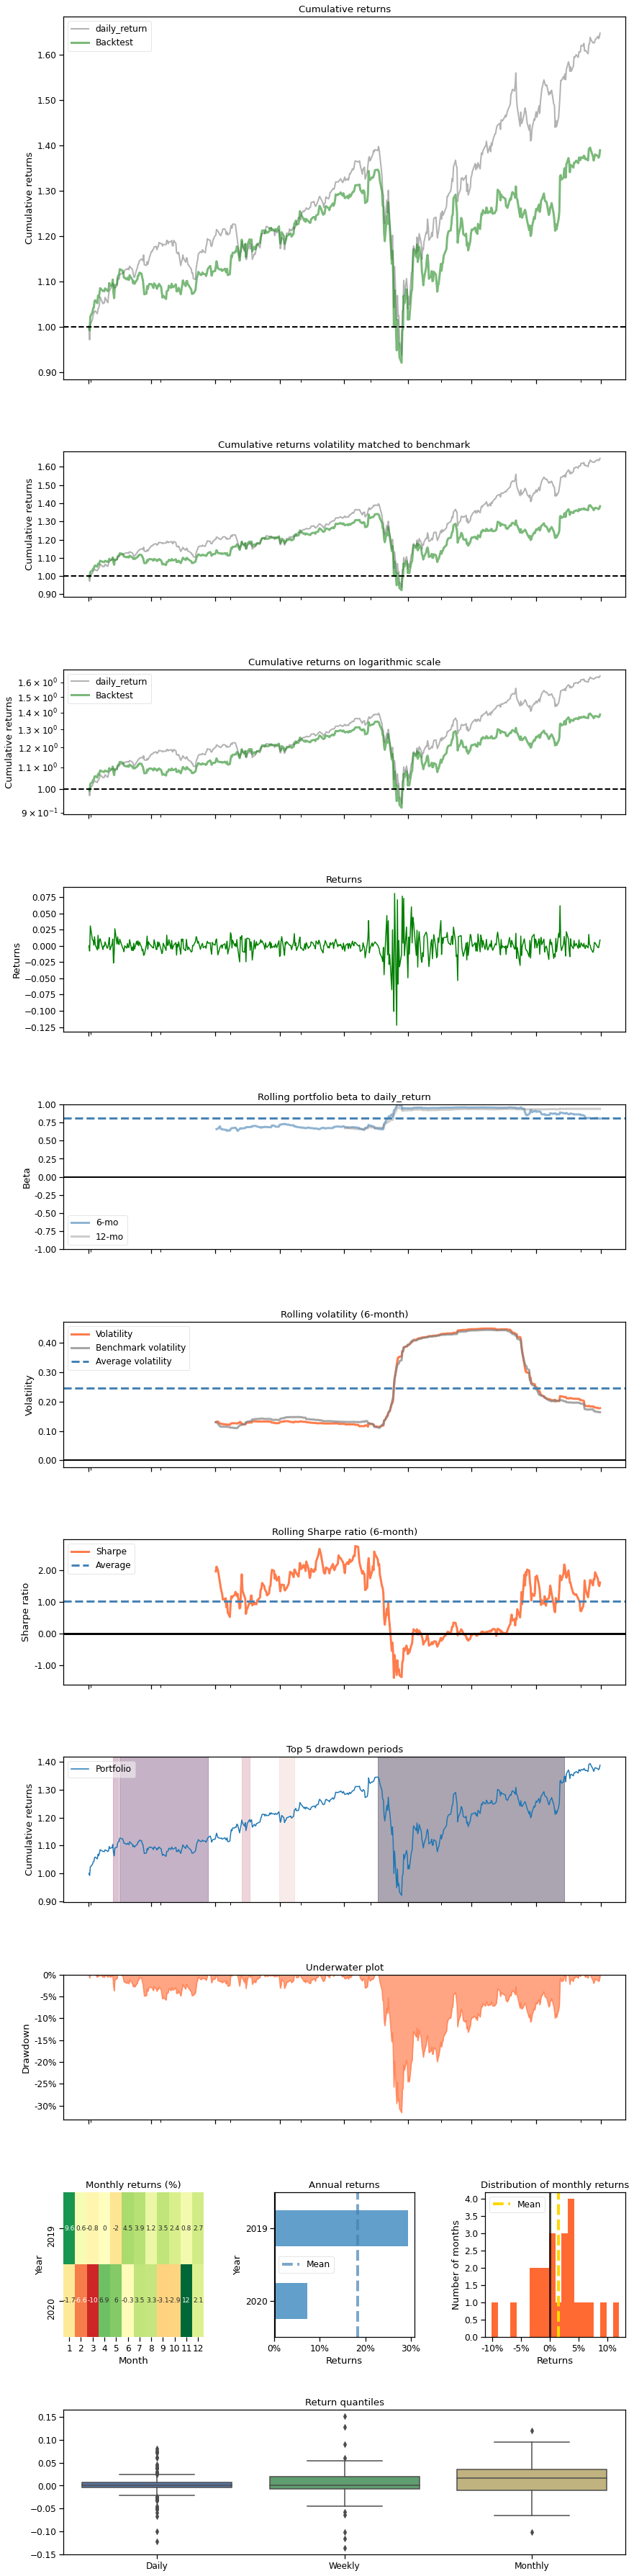

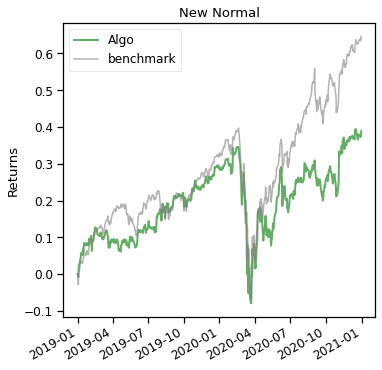

In [46]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [47]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:134721.33570394787
Sharpe:  0.6953885404174587
hit end!


In [48]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.012428
2,2019-01-04,0.035832
3,2019-01-07,0.009248
4,2019-01-08,0.010017
...,...,...
500,2020-12-24,0.006980
501,2020-12-28,-0.002871
502,2020-12-29,-0.003926
503,2020-12-30,0.003543


In [49]:
df_actions.head()

,BIIB,CB,EA,ECL,ED,FISV,GWW,HAS,K,WELL
date,,,,,,,,,,
2019-01-02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2019-01-03,0.079498,0.079498,0.079498,0.191505,0.079498,0.079498,0.092429,0.079498,0.159579,0.079498
2019-01-04,0.083374,0.085360,0.168347,0.161778,0.084274,0.083374,0.083374,0.083374,0.083374,0.083374
2019-01-07,0.130416,0.047977,0.119870,0.095348,0.130416,0.097989,0.054844,0.130416,0.090759,0.101964
2019-01-08,0.079172,0.079172,0.085085,0.215212,0.079172,0.100847,0.097186,0.079172,0.079172,0.105809


In [50]:
df_actions.to_csv('df_actions_ppo_20_1.csv')

In [51]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [52]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.160353
Cumulative returns      0.347213
Annual volatility       0.264571
Sharpe ratio            0.695389
Calmar ratio            0.448571
Stability               0.246282
Max drawdown           -0.357474
Omega ratio             1.157654
Sortino ratio           0.974645
Skew                   -0.570880
Kurtosis               14.758897
Tail ratio              0.923832
Daily value at risk    -0.032603
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,16.035%
Cumulative returns,34.721%
Annual volatility,26.457%
Sharpe ratio,0.70
Calmar ratio,0.45
Stability,0.25
Max drawdown,-35.747%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.75,2020-02-05,2020-03-23,2020-11-16,204
1,4.03,2019-02-05,2019-02-07,2019-02-15,9
2,3.39,2019-03-15,2019-04-22,2019-06-05,59
3,3.21,2020-01-23,2020-01-31,2020-02-05,10
4,3.15,2019-09-30,2019-10-25,2019-11-26,42


Stress Events,mean,min,max
New Normal,0.07%,-12.48%,10.57%


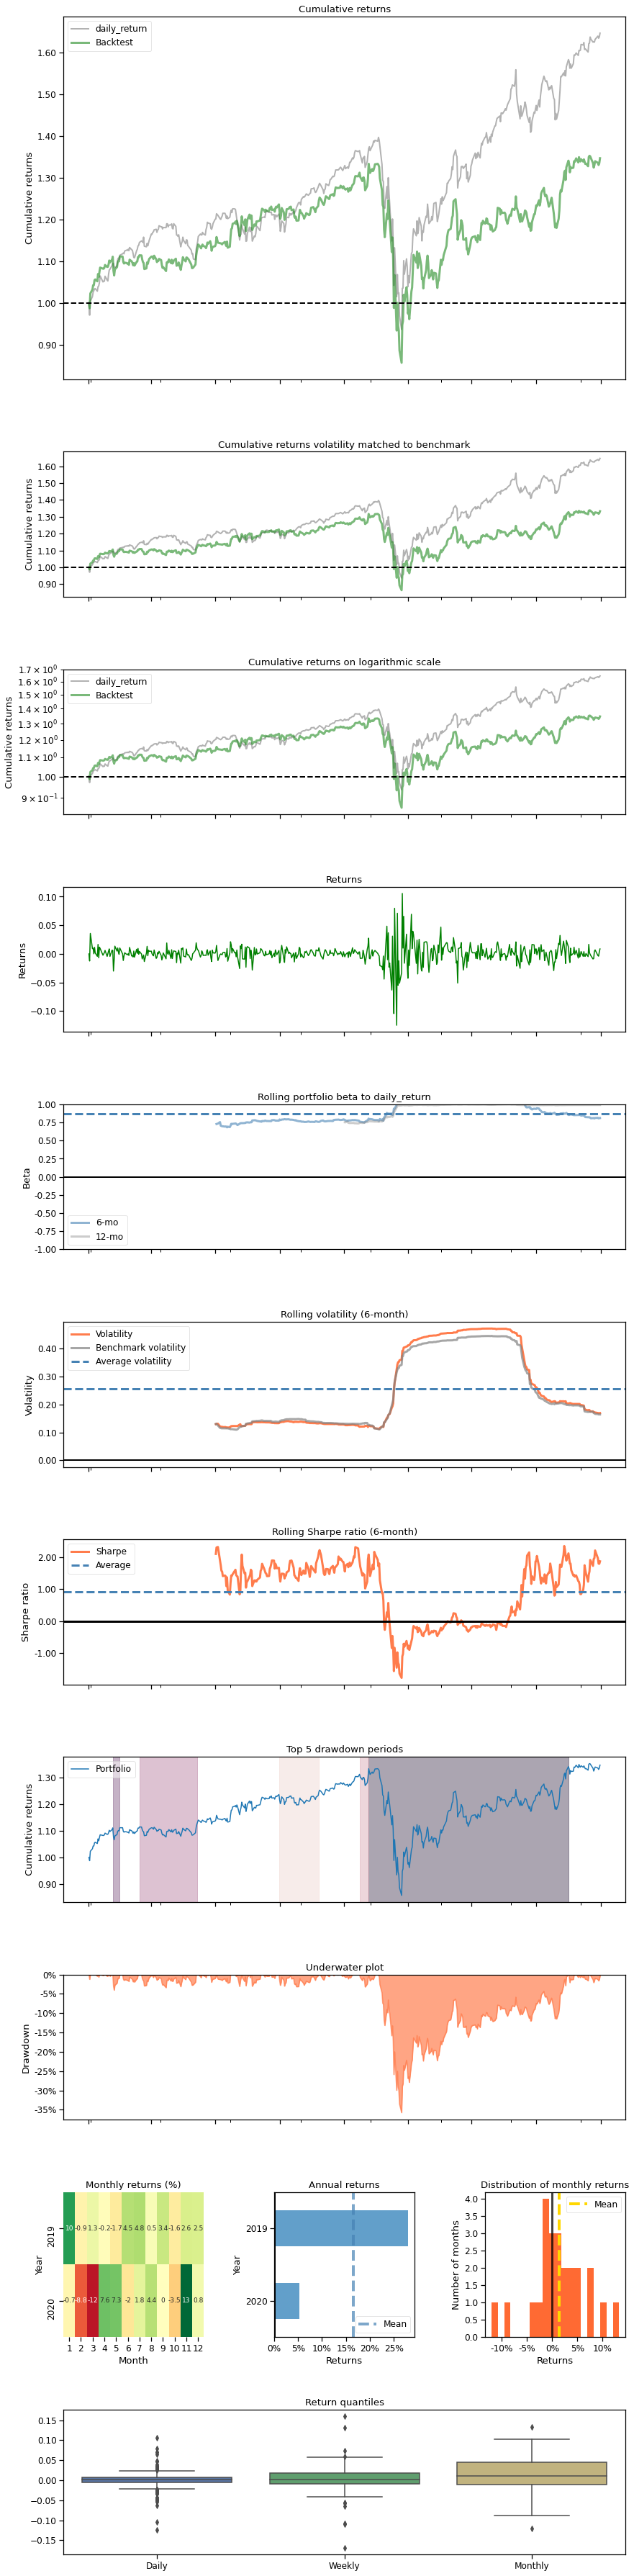

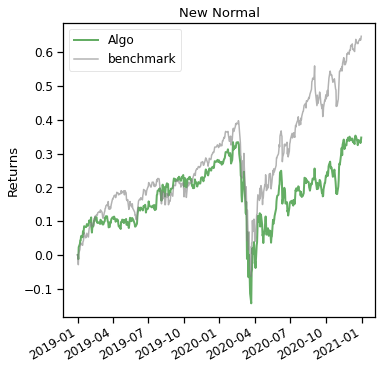

In [53]:
import pyfolio

%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [54]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:142052.45998022842
Sharpe:  0.8194043744455758
hit end!


In [55]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.011002
2,2019-01-04,0.032977
3,2019-01-07,0.007350
4,2019-01-08,0.009748
...,...,...
500,2020-12-24,0.007377
501,2020-12-28,-0.001838
502,2020-12-29,-0.003210
503,2020-12-30,0.003917


In [56]:
df_actions

,BIIB,CB,EA,ECL,ED,FISV,GWW,HAS,K,WELL
date,,,,,,,,,,
2019-01-02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2019-01-03,0.100238,0.058809,0.149443,0.080609,0.142014,0.059929,0.147462,0.057596,0.114460,0.089440
2019-01-04,0.129042,0.074433,0.134770,0.073731,0.166903,0.066036,0.113390,0.064837,0.107622,0.069236
2019-01-07,0.163981,0.065568,0.146935,0.087428,0.174641,0.064689,0.078197,0.064507,0.082238,0.071817
2019-01-08,0.123376,0.067689,0.161052,0.138291,0.172159,0.064505,0.068463,0.063872,0.071296,0.069297
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.102111,0.057357,0.068950,0.149839,0.118643,0.065707,0.080619,0.058252,0.144269,0.154253
2020-12-28,0.087319,0.051790,0.127344,0.136720,0.122284,0.064540,0.115076,0.051651,0.126852,0.116423
2020-12-29,0.083326,0.059525,0.062552,0.154864,0.138193,0.084065,0.074028,0.059301,0.137279,0.146867


In [57]:
df_actions.to_csv('df_actions_sac_20_1.csv')

In [58]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [59]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.191443
Cumulative returns      0.420525
Annual volatility       0.253170
Sharpe ratio            0.819404
Calmar ratio            0.601028
Stability               0.519154
Max drawdown           -0.318527
Omega ratio             1.187577
Sortino ratio           1.159818
Skew                   -0.576700
Kurtosis               13.836457
Tail ratio              0.926202
Daily value at risk    -0.031073
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,19.144%
Cumulative returns,42.052%
Annual volatility,25.317%
Sharpe ratio,0.82
Calmar ratio,0.60
Stability,0.52
Max drawdown,-31.853%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.85,2020-02-18,2020-03-23,2020-11-09,190
1,4.94,2019-03-15,2019-03-22,2019-06-05,59
2,3.75,2019-02-05,2019-02-07,2019-02-12,6
3,3.28,2019-09-30,2019-10-08,2019-10-22,17
4,3.09,2019-08-08,2019-08-14,2019-08-19,8


Stress Events,mean,min,max
New Normal,0.08%,-11.81%,8.74%


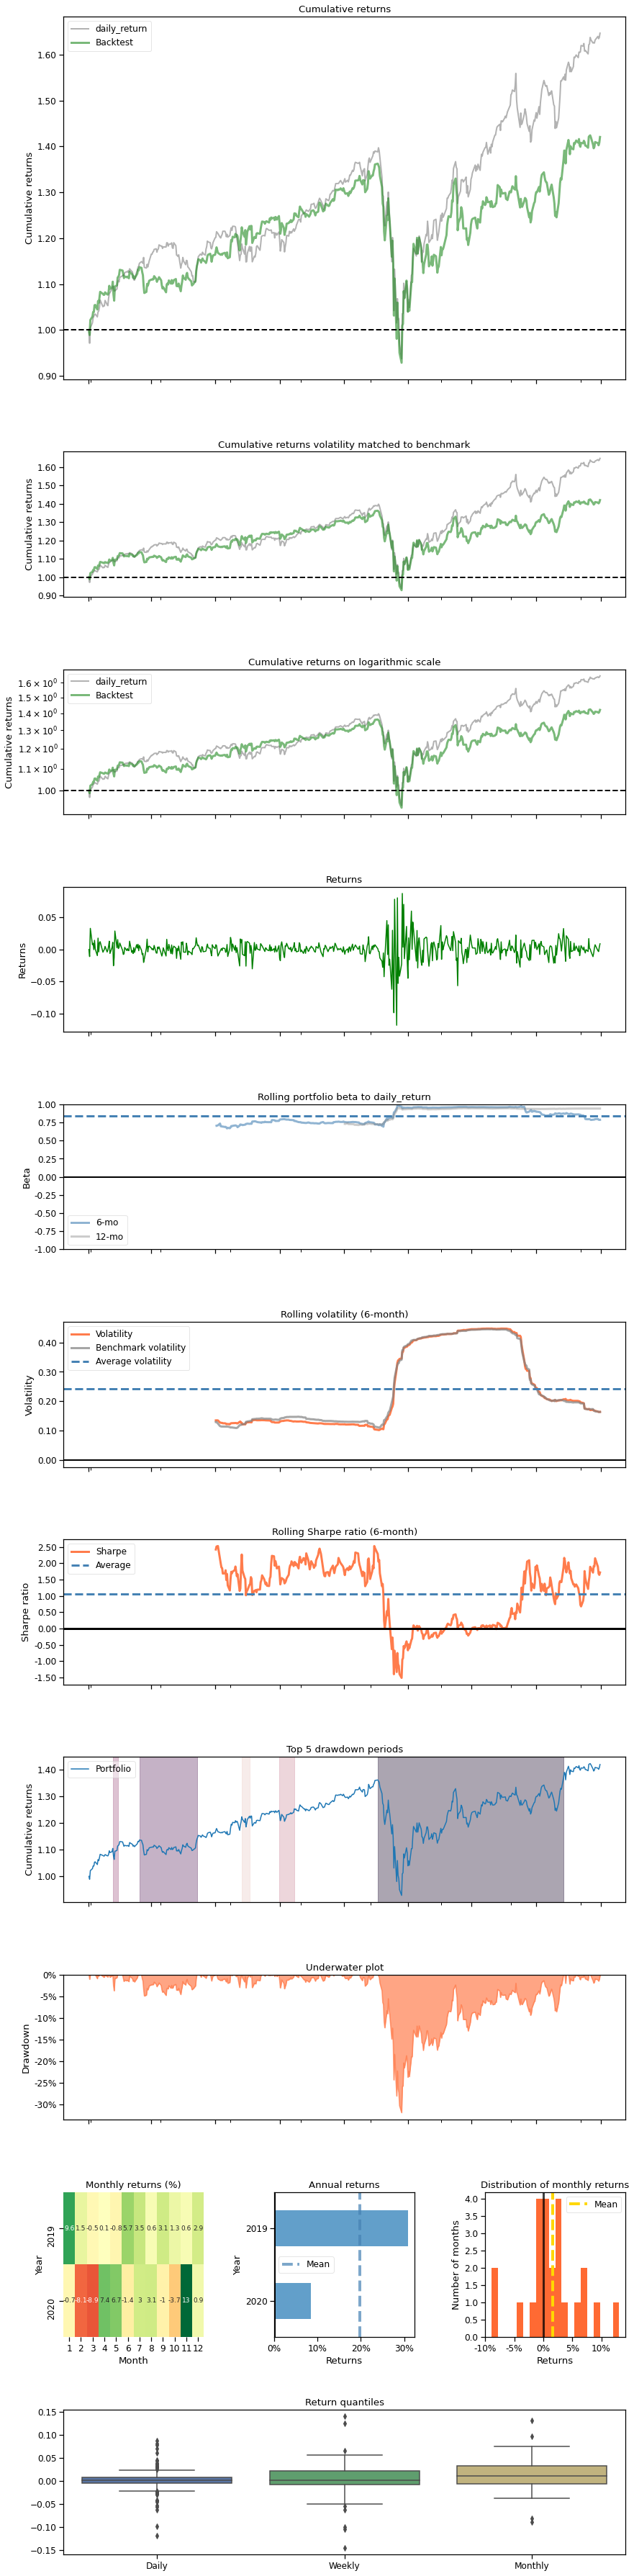

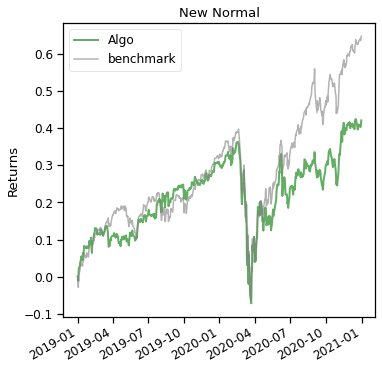

In [60]:
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)